# RWDL Deep Learning part

## Loading core libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from PIL import ImageFile
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Input, Conv2DTranspose
import cv2
import tensorflow as tf


## Declaration of basic constants

In [2]:
no_path = '../wm-nowm/train/no-watermark/'
water_path = '../wm-nowm/train/watermark/'
val_path_water = '../wm-nowm/valid/watermark/'
val_path_nowater = '../wm-nowm/valid/no-watermark/'
img_width, img_height = 128, 128
batch_size = 8
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Base loading functions

In [3]:
def takeFileName(filedir): 
    filename = np.array(filedir.split('/'))[-1] 
    return filename

### Function to search for images in selections that have an answer

In [4]:
def matchFileNames(watermarkedarr, nonwatermarkedarr, dname_wm, dname_nwm):
    sortedwmarr = np.array([])
    sortednwmarr = np.array([])
    
    wmarr = list(watermarkedarr)
    nwmarr = list(nonwatermarkedarr)
    
    length = len(watermarkedarr) if len(watermarkedarr) >= len(nonwatermarkedarr) else len(nonwatermarkedarr)
    
    for pos in range(length):
        try:
            if length == len(watermarkedarr): 
                exist_nwm = nwmarr.index(wmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[pos])
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[exist_nwm]) 
            elif length == len(nonwatermarkedarr): 
                exist_wm = wmarr.index(nwmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[exist_wm])
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[pos])
        except ValueError: 
            continue
    return sortedwmarr, sortednwmarr

### Separation of images into training and test sets

In [5]:
tp_watermarked = np.array([]) 
tp_nonwatermarked = np.array([])

for root, dirs, files in os.walk(water_path, topdown=True): 
    for file in files:
        tp_watermarked = np.append(tp_watermarked, takeFileName(file)) 
    
for root, dirs, files in os.walk(no_path, topdown=True):
    for file in files:
        tp_nonwatermarked = np.append(tp_nonwatermarked, takeFileName(file)) 
        
tp_watermarked_sorted, tp_nonwatermarked_sorted = matchFileNames(tp_watermarked, tp_nonwatermarked, water_path, no_path)


val_watermarked = np.array([])
val_nonwatermarked = np.array([])

for root, dirs, files in os.walk(val_path_water, topdown=True): 
    for file in files:
        val_watermarked = np.append(val_watermarked, takeFileName(file))
    
for root, dirs, files in os.walk(val_path_nowater, topdown=True): 
    for file in files:
        val_nonwatermarked = np.append(val_nonwatermarked, takeFileName(file))
        
val_watermarked_sorted, val_nonwatermarked_sorted = matchFileNames(val_watermarked, val_nonwatermarked, val_path_water, val_path_nowater)

### Create images from the database

In [6]:
def createPixelArr(files, width, height):
    data = []
    for image in files:
        try: # take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
        except Exception as e:
            print(e)
    return np.array(data)

## Creating a training sample

In [7]:
xTrain = createPixelArr(tp_watermarked_sorted, img_width, img_height)
yTrain = createPixelArr(tp_nonwatermarked_sorted, img_width, img_height)
xVal = createPixelArr(val_watermarked_sorted, img_width, img_height)
yVal = createPixelArr(val_nonwatermarked_sorted, img_width, img_height)

**Normalizing data**

In [8]:
xTrain = xTrain / 255
yTrain = yTrain / 255
xVal = xVal / 255
yVal = yVal / 255

In [9]:
val_dataset = tf.data.Dataset.from_tensor_slices((xVal, yVal))
val_dataset = val_dataset.batch(64)

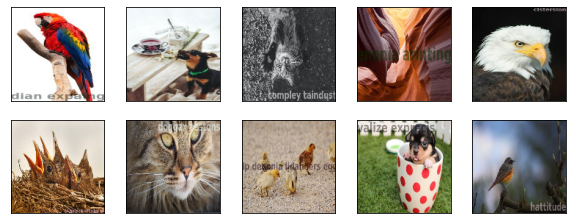

In [10]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xTrain[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

## Autoencoder model

In [11]:
def baseAutoencoder(width, height):
    minWeight = width
    maxWeight = width * 2
    shape=(width, height, 3)
    img_input = Input((shape))

    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x)
    

    x = Conv2DTranspose(maxWeight, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(maxWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(minWeight, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(minWeight, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error') 

    return model 

In [12]:
modelAutoEncoder = baseAutoencoder(img_width, img_height)
modelAutoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0     

C:\Users\xande\anaconda3\envs\tfvenv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = modelAutoEncoder.fit(xTrain, yTrain, epochs=80, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/80
218/218 [==============================] - 52s 206ms/step - loss: 0.0196 - val_loss: 0.0749
Epoch 2/80
218/218 [==============================] - 36s 164ms/step - loss: 0.0114 - val_loss: 0.0256
Epoch 3/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 4/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 5/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 6/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0081 - val_loss: 0.0056
Epoch 7/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 8/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 9/80
218/218 [==============================] - 36s 165ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 10/80
218/218 [==============================] - 36s 165ms/step - l

In [16]:
modelAutoEncoder.save_weights('../weights/modelAuto.h5') # Сохраняем модель

In [17]:
modelAutoEncoder = baseAutoencoder(img_width, img_height)
modelAutoEncoder.load_weights('../weights/modelAuto.h5') # Загружаем модель

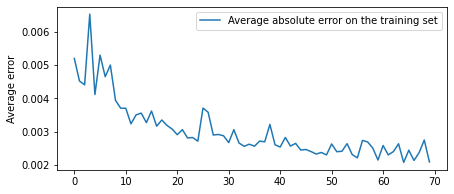

In [18]:
plt.figure(figsize=(7,3))
plt.plot(history.history['val_loss'][10:], 
         label='Average absolute error on the training set')
plt.ylabel('Average error')
plt.legend()
plt.show()

## Look at the results of the test sample

In [19]:
res = modelAutoEncoder.predict(xVal)
modelAutoEncoder.evaluate(xVal, res)

4/4 [==============================] - 1s 149ms/step - loss: 0.0000e+00


0.0

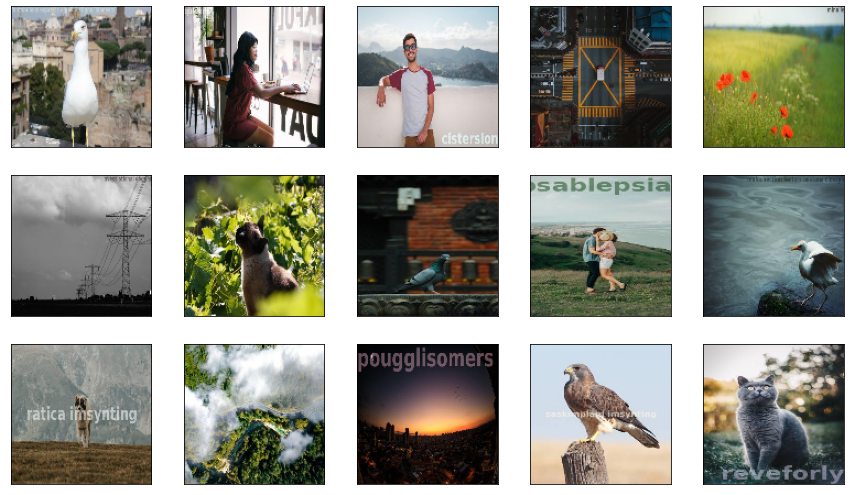

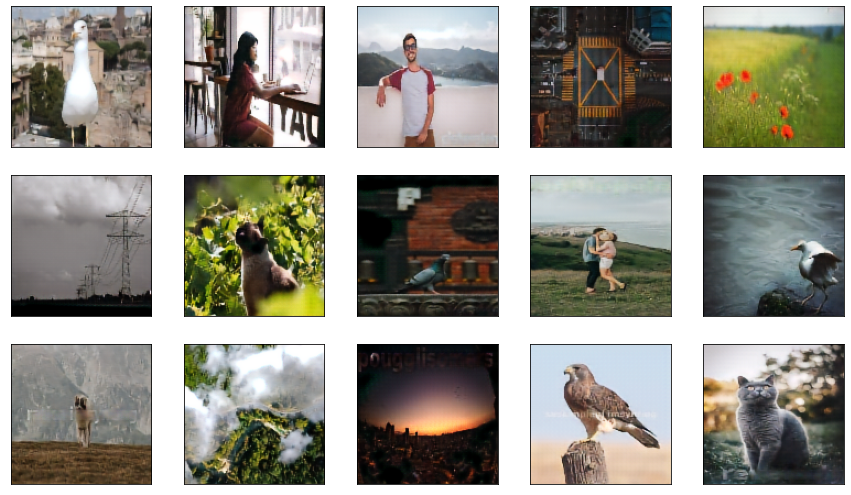

In [20]:
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xVal[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(res[i], cv2.COLOR_BGR2RGB))
plt.show()